# Get Vehicle Resale Price and Specs
> Group Member: Jiabo Cheng, Zili Huang <br>
Github: https://github.com/cheng-jiab/hw01

## Abstract

We are working on a vehicle dataset with information gathered from web scrapping, open api and downloadable csv file. We will munging the data and perform several operations to reform the dataset into an Entity-Relationship structure. After auditing and cleaning data, we will visualize the dataset and conclude the result we could get.


## Data
* Open data(Downloadable csv file):
    * NHTSA vPIC Database: Manufacture(top30).csv
> Dataset include name of manufacutres in United States market. 
Link: https://vpic.nhtsa.dot.gov/api/vehicles/GetMakesForVehicleType/car?format=csv
    * United States Environmental Protection Agency(EPA): all_alpha_20.csv
> Dataset include vehicle specs and EPA air pollution score. Link:  https://www.fueleconomy.gov/feg/download.shtml

* API: NHTSA Open API: 
> Dataset include all the veichle models made the by manufactures. Link: https://vpic.nhtsa.dot.gov/api/

* Web Scrapping: https://www.truecar.com
> Searching for the new car price and the used car trade-in price.

### Importing Libraries

In [84]:
import urllib
import requests
import json
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datasource1 - NHTSA Vehicle Api

### Fetch the vehicle models based on the manufacture, year and vehicle type.
#### API Example:
Here is the example of json farmat returned from NHTSA Api.

In [87]:
url = "https://vpic.nhtsa.dot.gov/api/vehicles/GetModelsForMakeIdYear/makeId/474/modelyear/2015?format=json"
req = urllib.request.Request(url=url)
json_obj = urllib.request.urlopen(req)
data = json.load(json_obj)
result = (data)['Results']
print (result[0])

{'Make_ID': 474, 'Make_Name': 'Honda', 'Model_ID': 1861, 'Model_Name': 'Accord'}


#### Relavent Code:

In [ ]:
def get_data(make):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:23.0) Gecko/20100101 Firefox/23.0'}
    url = "https://vpic.nhtsa.dot.gov/api/vehicles/GetModelsForMakeYear/make/" + make + "/vehicletype/passenger%20car?format=json"
    req = urllib.request.Request(url=url, headers=headers)
    json_obj = urllib.request.urlopen(req)
    data = json.load(json_obj)
    result = (data)['Results']
    return result

## Datasource2 - Truecar.com Website Scrapping

### Fetch MSRP (Manufacturer’s Suggested Retail Price) and Resale Price based on models.
#### Website Example:
Check the model: BMW M4 search result: 

In [101]:
url = "https://www.truecar.com/new-cars-for-sale/listings/bmw/m4/location-boston-ma/"

html= urllib.request.urlopen(url).read()
soup= BeautifulSoup(html, features="html.parser")
#print(soup.find(attrs={"data-test" : "vehicleListing"}))

Extract the model name and the price

In [15]:
card=soup.find_all(attrs={"data-test" : "vehicleListing"})
for item in card:
    name = item.find('h4',{"data-test":"vehicleListingCardTitle"}).get_text()
    price = item.find('h4',{"data-test":"vehicleListingPriceAmount"}).get_text()    
    price = price.replace('$', '')# Reforamt for the next processing
    price = price.replace(',', '')# Reforamt for the next processing

    print(name,price)

2020 BMW M4 CS Coupe 106295
2020 BMW M4 Convertible 98530
2020 BMW M4 Coupe 86120
2020 BMW M4 CS Coupe 106295
2020 BMW M4 CS Coupe 106295
2020 BMW M4 Coupe 87485
2020 BMW M4 CS Coupe 113895
2020 BMW M4 Coupe 86795
2020 BMW M4 Coupe 83895


#### Relavent Code: (Fetch new car price)

In [ ]:
def fetch_price(brand,model):
    sum=0
    count=0
    url = "https://www.truecar.com/new-cars-for-sale/listings/" + brand+ "/"+model + "/location-boston-ma/"
    print(url)
    html= urllib.request.urlopen(url).read()
    soup= BeautifulSoup(html, features="html.parser")

    avail = soup.find('h4',{'data-qa':'Heading'}).get_text()
    if avail == "You filtered out all available listings.":
        print(url,"No Price Available")
        return

    card=soup.find_all(attrs={"data-test" : "vehicleListing"})
    for item in card:
        name = item.find('h4',{"data-test":"vehicleListingCardTitle"}).get_text()
        price = item.find('h4',{"data-test":"vehicleListingPriceAmount"}).get_text()
        if re.search(model,name, re.IGNORECASE): #Make sure the model retured is correct.
            price = price.replace('$', '')
            price = price.replace(',', '')
            sum=sum+int(price)
            count=count+1
        else:
            print(url,"error")

    if count == 0:
        print(url,"No available price")
        return
    else:
        return sum/count


#### Relavent Code: (Fetch used car price)

In [ ]:
def fetch_used_price(brand,model):
    count=0
    url = "https://www.truecar.com/used-cars-for-sale/listings/" + brand+ "/"+model + "/location-boston-ma/"
    html= urllib.request.urlopen(url).read()
    soup= BeautifulSoup(html, features="html.parser")
    avail = soup.find('h4',{'data-qa':'Heading'}).get_text()

    if avail == "You filtered out all available listings.":
        print(url,"No Price Available")
        return "-"
    
    card=soup.find_all(attrs={"data-test" : "vehicleListing"})
    year = list()
    price_set = list()
    for item in card:
        name = item.find('h4',{"data-test":"vehicleListingCardTitle"}).get_text()
        price = item.find('h4',{"data-test":"vehicleListingPriceAmount"}).get_text()
        if re.search(model,name, re.IGNORECASE):
            price = price.replace('$', '')
            price = price.replace(',', '')
            if price != "N/A":
                count=count+1
                #print(name[0:4],price)
                year.append(str(name[0:4]))
                price_set.append(int(price))
                #print(year,price_set)
                dict = {"year": year, "price": price_set}
                data = pd.DataFrame(dict)
        else:
            print(url,"error")
    if count == 0:
        print(url,"No available price")
        return "-"
    else:
        r_year = data.groupby('year').mean() # Group the resale price by year, and calculate the mean.
        r_year = pd.DataFrame(r_year)
        y= r_year['price'].index.tolist() 
        p= r_year['price'].values.tolist()
        #print(r_year)

        index = range(0,1) # using a 1 row dataframe to reformat the result.
        df=pd.DataFrame(index=index, columns=['2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008'])
        i=0
        for item in y:
            if item in "'2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010,'2009','2008'":
                df.loc[0,item] = p[i]
                i=i+1
        return df.values.tolist()


## Datasource3 - EPA Fuel Economy Data
### Fetch vehicle specs and EPA economy score.
#### Relavent Code:

In [ ]:
spec = item['Make_Name'].upper() + " " + item['Model_Name']
with open('all_alpha_20.csv')as m:
    m_csv = csv.reader(m)
    headers = next(m_csv)
    for info in m_csv:
        if spec in info[0]:
            row.append(info[1])
            row.append(info[2])
            row.append(info[10])
            row.append(info[11])
            break

## Conceptual Model

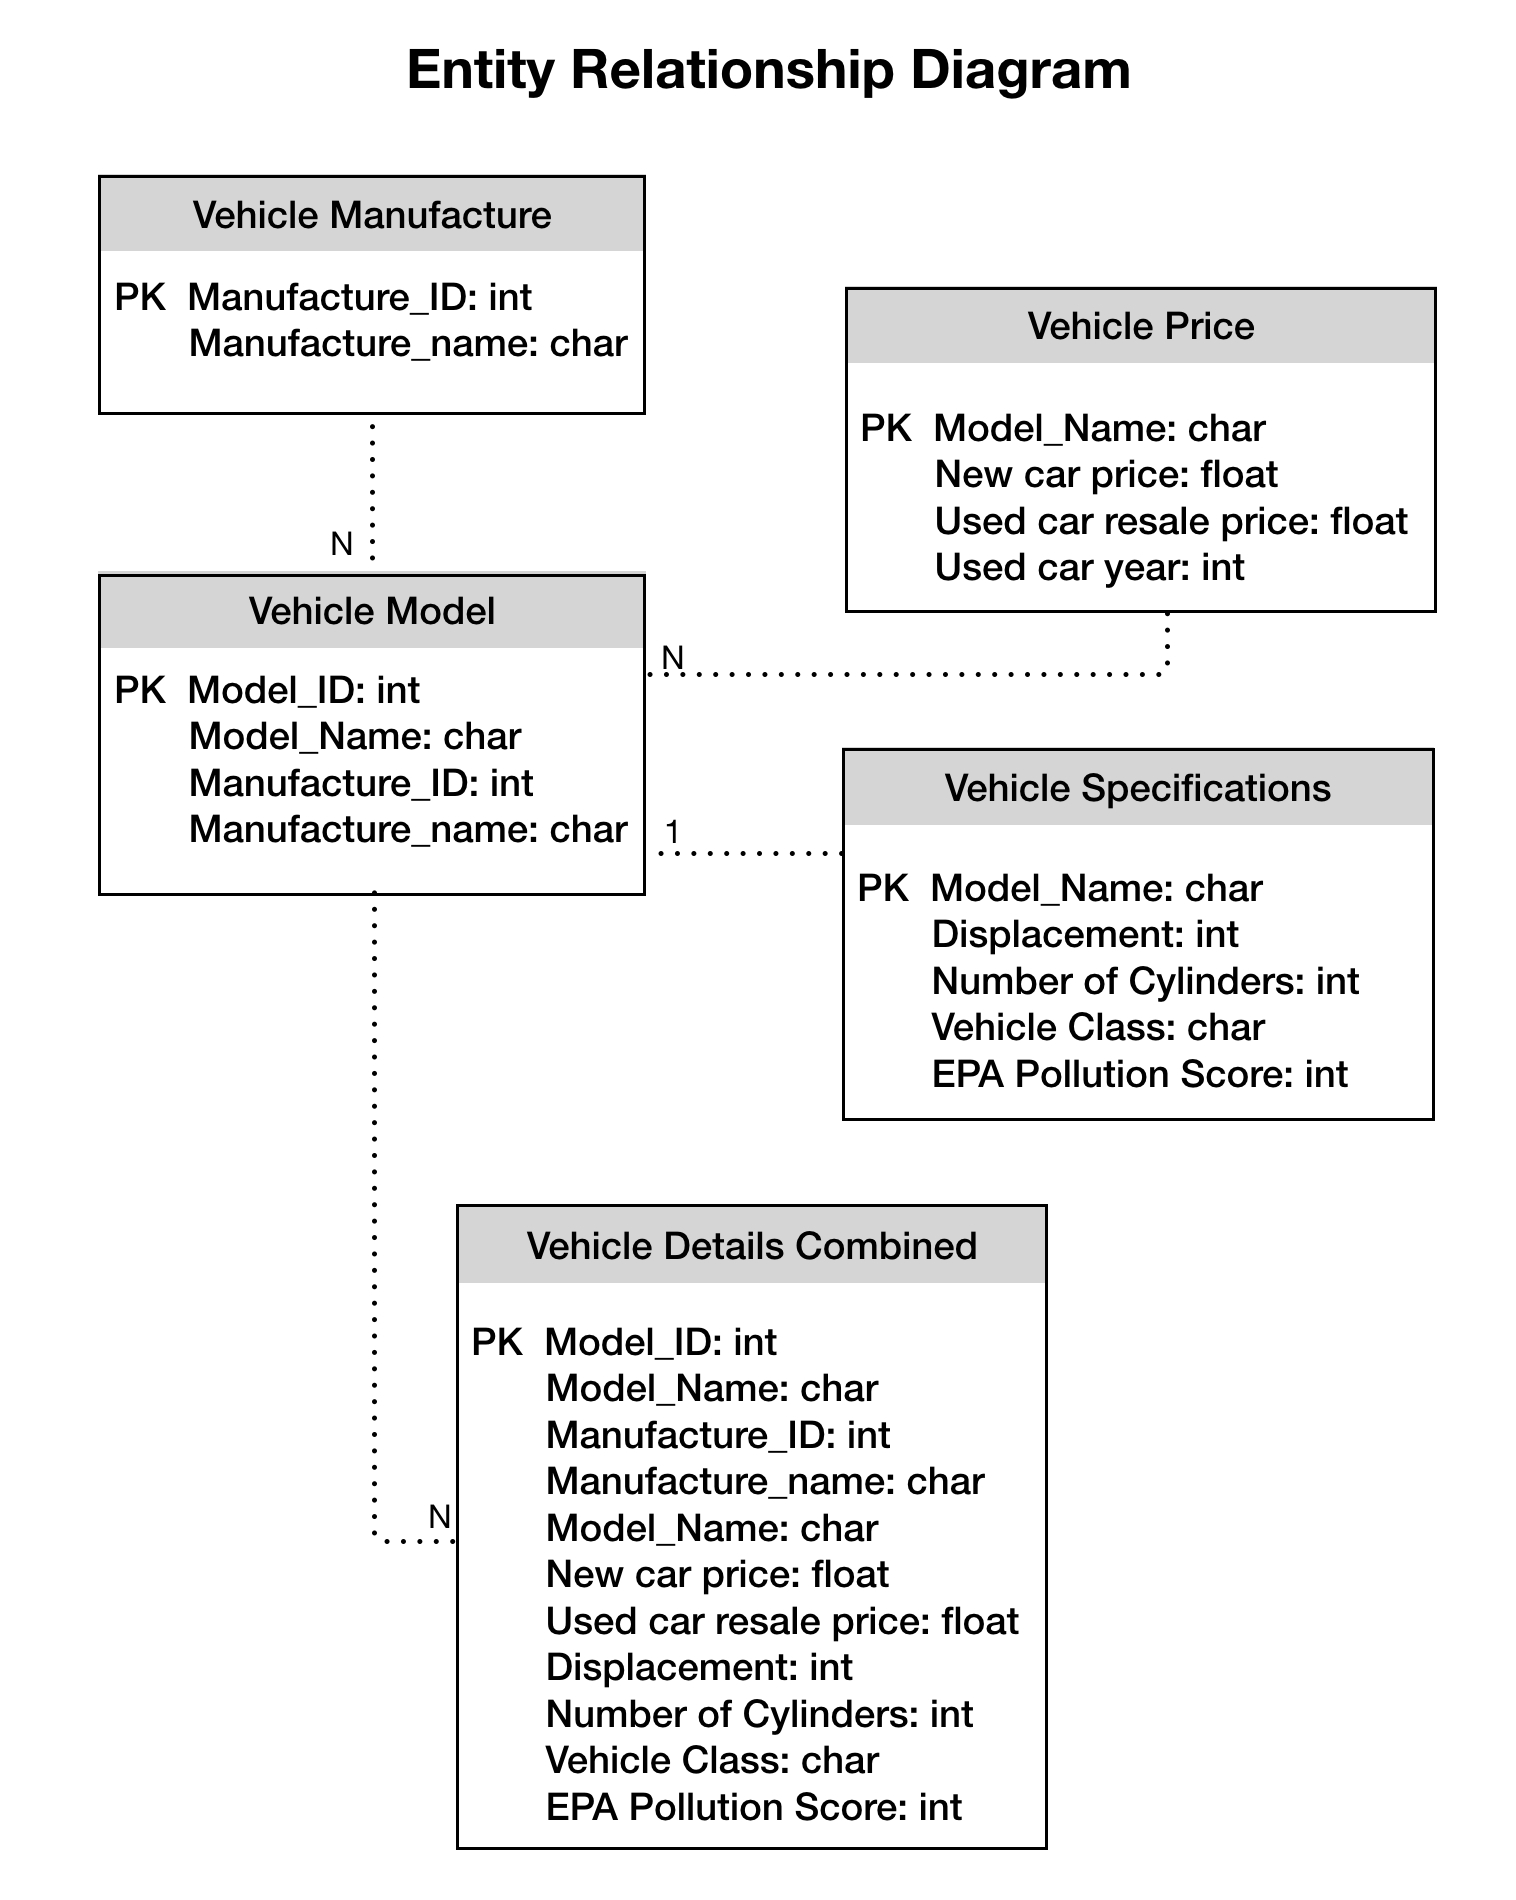

In [108]:
from IPython.display import Image
Image('ERD.png')

## Munging the data, reformatting and saving in csv file:
#### Relavent Code:

In [ ]:
for item in result:
    brand = item['Make_Name'].lower()
    model = item['Model_Name'].lower()
    brand = brand.replace(" ","-")
    model = model.replace(" ",'-')
    new = fetch_price(brand,model)
    row = [item['Make_ID'], item['Make_Name'], item['Model_ID'], item["Model_Name"]]
    if new !=  None:
        used = fetch_used_price(brand,model)
        row = [item['Make_ID'],item['Make_Name'],item['Model_ID'],item["Model_Name"], new ]
        for i in used:
            row.extend(i)

    with open('model.csv', 'a')as f:
        f_csv = csv.writer(f)
        f_csv.writerow(row)

with open('record.csv', 'a')as r: # saving web scrapping progress, avoid getting duplicated data.
    r_csv = csv.writer(r)
    r_csv.writerow([make])

## Data Cleaning
#### Open CSV file with the result of data mugging:

In [106]:
data = pd.read_csv("model.csv", index_col=3)
data.head()

,Make_ID,Make_Name,Model_ID,MSRP,2020,2019,2018,2017,2016,2015,...,2013,2012,2011,2010,2009,2008,Displacement,Cylinder,Vehicle Class,EPA Air Pollution Score
Model_Name,,,,,,,,,,,,,,,,,,,,,
TLX,475,Acura,5354,38719.333333,26799.5,30921.500000,30344.000000,21031.153846,18514.000000,18422.25,...,NaN,NaN,NaN,NaN,NaN,NaN,2.4,4.0,small car,3.0
RLX,475,Acura,2149,62995.000000,NaN,NaN,33086.428571,23564.000000,23100.000000,20308.00,...,NaN,NaN,NaN,NaN,NaN,NaN,3.5,6.0,midsize car,7.0
ILX,475,Acura,2150,29215.952381,NaN,22383.333333,19085.000000,17201.714286,16563.333333,10995.00,...,11533.25,NaN,NaN,NaN,NaN,NaN,2.4,4.0,small car,3.0
RL,475,Acura,1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TL,475,Acura,1873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
data.shape

(694, 21)

In [21]:
data.dtypes

Make_ID                      int64
Make_Name                   object
Model_ID                     int64
MSRP                       float64
2020                       float64
2019                       float64
2018                       float64
2017                       float64
2016                       float64
2015                       float64
2014                       float64
2013                       float64
2012                       float64
2011                       float64
2010                       float64
2009                       float64
2008                       float64
Displacement               float64
Cylinder                   float64
Vehicle Class               object
EPA Air Pollution Score    float64
dtype: object

####  Select the model with valid new car price (MSRP): (Keep data accuracy)

In [30]:
valid = data.loc[:,'MSRP']>0
v_df = data.loc[valid,:]
v_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, TLX to XC40
Data columns (total 21 columns):
Make_ID                    139 non-null int64
Make_Name                  139 non-null object
Model_ID                   139 non-null int64
MSRP                       139 non-null float64
2020                       10 non-null float64
2019                       106 non-null float64
2018                       102 non-null float64
2017                       121 non-null float64
2016                       106 non-null float64
2015                       90 non-null float64
2014                       88 non-null float64
2013                       71 non-null float64
2012                       55 non-null float64
2011                       34 non-null float64
2010                       37 non-null float64
2009                       25 non-null float64
2008                       21 non-null float64
Displacement               89 non-null float64
Cylinder                   89 non-null float64
V

#### Drop the rows with too little information:

In [59]:
dp = v_df.dropna(thresh = 12)
dp.shape

(96, 21)

#### Calculate the vehicle resale price change percentage per year:

In [60]:
price = dp.iloc[:,4:14]#18
percent = price.pct_change(axis='columns',fill_method='backfill')
percent.head()

,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011
Model_Name,,,,,,,,,,
TLX,NaN,0.153809,-0.018676,-0.306909,-0.119687,-0.004956,NaN,NaN,NaN,NaN
RLX,NaN,0.000000,0.000000,-0.287805,-0.019691,-0.120866,0.006828,NaN,NaN,NaN
ILX,NaN,0.000000,-0.147357,-0.098679,-0.037111,-0.336184,0.336971,-0.215425,NaN,NaN
A4,NaN,0.000000,0.000000,-0.036446,-0.199000,-0.260069,-0.051160,-0.111173,-0.377736,0.304724
A6,NaN,0.000000,-0.072015,0.000000,-0.180935,-0.261664,-0.084622,0.176149,-0.428725,-0.087555


#### Calculate the vehicle resale price average change percentage from 2020 to 2008:

In [61]:
percent.mean(1).head()

Model_Name
TLX   -0.059284
RLX   -0.070256
ILX   -0.071112
A4    -0.081207
A6    -0.104374
dtype: float64

#### Combine the change percentage table with original table

In [62]:
res = pd.concat([v_df,percent,percent.mean(1)],axis=1, join_axes=[v_df.index])
res.columns = ['Make_ID','Make_Name','Model_ID','MSRP','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008','Displacement','Cylinder','Vehicle Class','EPA','-','n-u','u2019','u2018','u2017','u2016','u2015','u2014','u2013','u2012','ave']

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


#### Sort the models with the average percent change.
##### Top 10 models with least resale price drop:

In [63]:
print(res.sort_values(by='ave',ascending=False)['ave'].head(10))

Model_Name
Camaro       -0.005865
Corvette     -0.013544
Challenger   -0.017358
Optima       -0.021918
Rio          -0.025721
370Z         -0.039929
Sonic        -0.041635
TTS          -0.041867
Impreza      -0.045470
Camry        -0.046822
Name: ave, dtype: float64


## Data Visualization.

Now we could easily picture various plots to analyse the dataset.
### Line plot with Resale Value in time series:

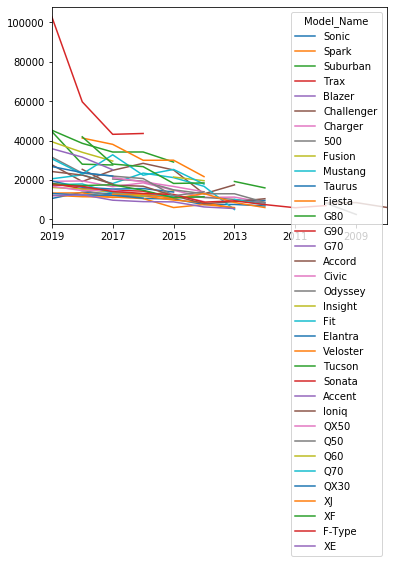

In [97]:
p_y = res.iloc[35:70,5:17].T
p_y.plot()
plt.show()

#### Conclusion: The trade-in value of used car drops fast in first 2 years, and drops slower in next few years.
### Scatter plot with Resale Price Average Change Percentage v.s. MSRP (Manufacturer’s Suggested Retail Price)

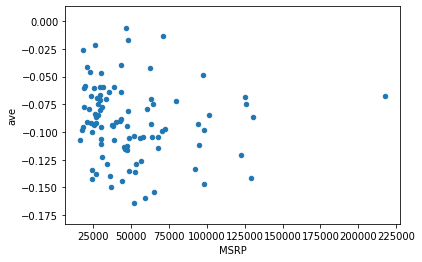

In [96]:
n_u= res.sort_values(by ='ave',ascending=False)
p_nu=n_u.iloc[:,[3,-1]]
p_nu.plot(kind='scatter', x='MSRP', y='ave')
plt.show()

#### Conclusion: There's no strong relationship between the new car price and the average resale price drop percentage.
### Resale price average drop rate v.s. Manufacture

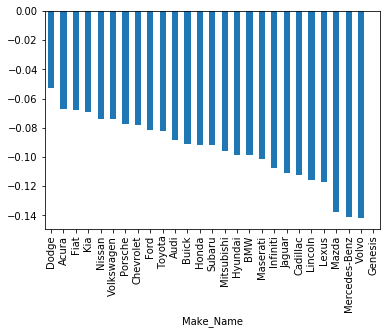

In [75]:
bran_ave=n_u.groupby('Make_Name').mean()
bran_ave= bran_ave.sort_values(by ='ave',ascending=False)
bran_ave = bran_ave['ave']
bran_ave.plot(kind='bar')
plt.show()

#### Conclusion: Top 5 brand with least trade-in value drop in US market is : Dodge, Acura, Fiat, Kia, and Nissan.
### Resale price average drop rate v.s. Vehicle Class

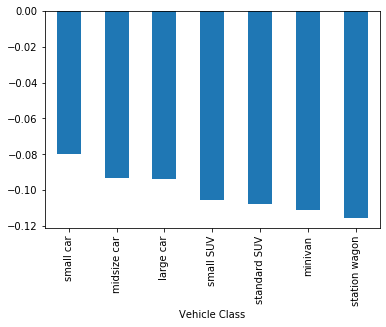

In [76]:
bran_ave=res.groupby('Vehicle Class').mean()
bran_ave= bran_ave.sort_values(by ='ave',ascending=False)
bran_ave = bran_ave['ave']
bran_ave.plot(kind='bar')
plt.show()

#### Conclusion: The most popular vehicle type in US market is : Small Car
### Resale price average drop rate v.s. number of cylinders

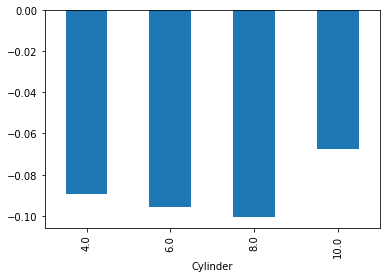

In [77]:
bran_ave=res.groupby('Cylinder').mean()
bran_ave = bran_ave['ave']
bran_ave.plot(kind='bar')
plt.show()

## Audit Accuracy
Since not all the models have valid sale price on the website, we have code to return Null value when no price available or wrong price get. Also, we use commands like dropna, check price>0 to confirm the data accuracy.

## Audit Consistency
The datasets which have been used in this assignment show a uniform relationship between each of the dataset since they are linked to each other by a common attribute.

## Report
* Files:
    * Files used: Manufacture(top30).csv, all_alpha_20.csv
    * Files generated: model.csv, record.csv
* Codes:
    * Step 1: Extraction of Data
        1. Using the API:<br>
        Using urllib.request to access the website, changing variables in the url to get models from different manufactures. <br>
        json library to read the data.
        2. Using the website to scrap the data:<br>
        Using urllib.request to access the website <br>
        BeautifulSoup library helps to scrap the contents of the web page.<br>
        find_all() method were used to extract the information we need.
        3. Loading the csv file: <br>
        Using csv library to read, write and append the csv file. Pandas to read the csv file and load into data frames.
    * Step 2: Auditing and cleaning the data: <br>
        To gain information about the dataset, we used method like shape, info, iloc, isnull,etc, concat data frames and reindex, dropna to cleaning the data.
        
## Conclusion
The assignment focusing on learning getting the data from various sources, munging the data and reformat the data to fit the conceptual database model, cleaning and auditing to make the dataset accurate. and visualizing the dataset to get useful conclusion.
## Contribution
We contributed by own: 70% <br>
By external sources: 30%
## Citations
https://github.com/nikbearbrown/INFO_6210/blob/master/Movie_DB_Example/Pandas_Data_Cleaning_Wrangling_and_Visualization.ipynb<br>
https://blog.csdn.net/u014662865/article/details/59058039<br>
https://morvanzhou.github.io/tutorials/data-manipulation/np-pd/3-2-pd-indexing/<br>
https://zhuanlan.zhihu.com/p/32572237<br>
https://blog.csdn.net/guoziqing506/article/details/52014506
    